## Including the cross correlations between bins

Similar exploration and plots as before, but now including the cross-correlations between bins.

In [61]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate 
from code.plot_utils import plot_pretty
from matplotlib import rcParams
rcParams['font.family'] = 'serif' 
%matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [62]:
from Ang_clust_WITH_cross import Fisher_calculator as Fisher_CROSS

Inputs of the function Fisher_CROSS (calculates Angular clustering in a given number of bins between given limits, taking into account the cross-correlations between bins)

Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_z, N_gal_tot, z_0, a, b)

- z_init, z_final : redshift limits we consider

- N_bis: number of bins

- f_sky: fraction of the sky used

- sig_z: photo-z scatter

- N_gal_tot: total number of galaxies

- z_0, a, b : parameters that describe the distribution

In [63]:
# Import function that marginalizes over the the nuisance parameters
from Tools import marginalize as marg
# Import function that adds a constant prior of the form sigma(sigma_z) = sigma(z_b), same in every bin
from Tools import priors_1
# Import function that adds a constant prior of the form sigma(sigma_z) = sigma(z_b) = alpha*sigma_z, same in every bin
from Tools import priors_2
# Similar to priors_2, but now fixing photo-z scatter
from Tools import priors_3
# Import function that calculates Figure of Merit
from Tools import FoM_return 

In [64]:
# Arrays of sample sizes and redshift errors 
# ======================================================
N_gal_arr = np.linspace(1.0e6, 8.0e7, 40)
sig_z_arr = np.linspace(0.01, 0.1, 40)
size = np.size(N_gal_arr)

In [65]:
# Survey parameters for the Fisher matrix 
# =====================================================
# =====================================================
z_init =  0.20 #Initial redshift
z_final = 0.95 #Final redshift
N_bins = 5 #Number of bins
f_sky = 5000.0/41253.0 # Fraction of the sky

# Parameters of the redshift distribution
z_0 = 0.50
a = 1.47
b = 2.09

# =====================================================
# =====================================================
# Parameters (size and redshift error for the particular samples I'm going to consider)

# redMaGiC-like sample
N_g_rm, sig_rm = 2.43e6, 0.017
# BAO-cuts like sample
N_g_CC, sig_CC = 1.74e7, 0.042
# Flux-limited like sample
N_g_fl, sig_fl = 6.75e7, 0.073

#### Define some priors - as before

In [66]:
# Define the optimistic and conservative see above
alpha_con = 0.4
alpha_opt = 0.04
# Define also an alpha that will actually result in fixed photo-z errors
# In other words, knowledge of the photo-zs with infinite accuracy
alpha_fix = 1.0e-10

In [67]:
# Initialize matrices
FoM_free = np.zeros([size,size])
FoM_pr_con1 = np.zeros([size,size]) # Conservative prior case
FoM_pr_opt1 = np.zeros([size,size]) # Optimistic prior case
FoM_fixed1 = np.zeros([size, size]) # Fixed photo-zs


FoM_pr_con2 = np.zeros([size,size]) # Conservative prior case
FoM_pr_opt2 = np.zeros([size,size]) # Optimistic prior case
FoM_fixed2 = np.zeros([size, size]) # Fixed photo-zs

In [68]:
for i in range(size):
    sig_z = sig_z_arr[i]
    for j in range(size):
        N_gal = N_gal_arr[j]
        
        #Calculate the free Fisher matrix 
        Fish_mat = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_z, N_gal, z_0, a, b)
        
        # Add the priors now 
        # ------------------------------------------------------------
        Fish_pr_con1 = priors_2(Fish_mat, N_bins, alpha_con, sig_z) #conservative prior
        Fish_pr_opt1 = priors_2(Fish_mat,N_bins, alpha_opt, sig_z) #optimistic prior
        Fish_fix1 = priors_2(Fish_mat, N_bins, alpha_fix, sig_z) # Fixed photo-z parameters
        
        #Calculate the Figure of Merit
        FoM_free[i][j] = FoM_return(Fish_mat)
        FoM_pr_con1[i][j] = FoM_return(Fish_pr_con1)
        FoM_pr_opt1[i][j] = FoM_return(Fish_pr_opt1)
        FoM_fixed1[i][j] = FoM_return(Fish_fix1)
        
        # ========================================================================
        # ========================================================================
        # Add the priors now - Second case
        # ------------------------------------------------------------
        Fish_pr_con2 = priors_3(Fish_mat, N_bins, alpha_con, sig_z) #conservative prior
        Fish_pr_opt2 = priors_3(Fish_mat,N_bins, alpha_opt, sig_z) #optimistic prior
        Fish_fix2 = priors_3(Fish_mat, N_bins, alpha_fix, sig_z) # Fixed photo-z parameters
        
        # Figure of Merit
        FoM_pr_con2[i][j] = FoM_return(Fish_pr_con2)
        FoM_pr_opt2[i][j] = FoM_return(Fish_pr_opt2)
        FoM_fixed2[i][j] = FoM_return(Fish_fix2)

#### Calculate the FoMs of the redMaGiC, CC and Flux Limited samples 

In [69]:
# Calculate the Fisher matrices - without priors for the three samples
Fish_mat_rm_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_rm, N_g_rm, z_0, a, b)
Fish_mat_CC_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_CC, N_g_CC, z_0, a, b)
Fish_mat_fl_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_fl, N_g_fl, z_0, a, b)

# ===========================================================================================
# ===========================================================================================

# Include the three priors

# Conservative priors
Fish_rm_con1 = priors_2(Fish_mat_rm_free, N_bins, alpha_con, sig_rm)
Fish_CC_con1 = priors_2(Fish_mat_CC_free, N_bins, alpha_con, sig_CC)
Fish_fl_con1 = priors_2(Fish_mat_fl_free, N_bins, alpha_con, sig_fl)

# Optimistic priors
Fish_rm_opt1 = priors_2(Fish_mat_rm_free, N_bins, alpha_opt, sig_rm)
Fish_CC_opt1 = priors_2(Fish_mat_CC_free, N_bins, alpha_opt, sig_CC)
Fish_fl_opt1 = priors_2(Fish_mat_fl_free, N_bins, alpha_opt, sig_fl)

# Fixed photo-zs 
Fish_rm_fix1 = priors_2(Fish_mat_rm_free, N_bins,alpha_fix, sig_rm)
Fish_CC_fix1 = priors_2(Fish_mat_CC_free, N_bins, alpha_fix, sig_CC)
Fish_fl_fix1 = priors_2(Fish_mat_fl_free, N_bins, alpha_fix, sig_fl)

# Conservative priors
Fish_rm_con2 = priors_3(Fish_mat_rm_free, N_bins, alpha_con, sig_rm)
Fish_CC_con2 = priors_3(Fish_mat_CC_free, N_bins, alpha_con, sig_CC)
Fish_fl_con2 = priors_3(Fish_mat_fl_free, N_bins, alpha_con, sig_fl)

# Optimistic priors
Fish_rm_opt2 = priors_3(Fish_mat_rm_free, N_bins, alpha_opt, sig_rm)
Fish_CC_opt2 = priors_3(Fish_mat_CC_free, N_bins, alpha_opt, sig_CC)
Fish_fl_opt2 = priors_3(Fish_mat_fl_free, N_bins, alpha_opt, sig_fl)

# Fixed photo-zs 
Fish_rm_fix2 = priors_3(Fish_mat_rm_free, N_bins,alpha_fix, sig_rm)
Fish_CC_fix2 = priors_3(Fish_mat_CC_free, N_bins, alpha_fix, sig_CC)
Fish_fl_fix2 = priors_3(Fish_mat_fl_free, N_bins, alpha_fix, sig_fl)

# ============================================================================================
# ============================================================================================

# Now calculate the FoMs

# Free - no priors
FoM_rm_free = FoM_return(Fish_mat_rm_free)
FoM_CC_free = FoM_return(Fish_mat_CC_free)
FoM_fl_free = FoM_return(Fish_mat_fl_free)

# Conservative priors
FoM_rm_con1 = FoM_return(Fish_rm_con1)
FoM_CC_con1 = FoM_return(Fish_CC_con1)
FoM_fl_con1 = FoM_return(Fish_fl_con1)

# Optimistic priors
FoM_rm_opt1 = FoM_return(Fish_rm_opt1)
FoM_CC_opt1 = FoM_return(Fish_CC_opt1)
FoM_fl_opt1 = FoM_return(Fish_fl_opt1)

# Fixed photo-zs
FoM_rm_fix1 = FoM_return(Fish_rm_fix1)
FoM_CC_fix1 = FoM_return(Fish_CC_fix1)
FoM_fl_fix1 = FoM_return(Fish_fl_fix1)

# Conservative priors
FoM_rm_con2 = FoM_return(Fish_rm_con2)
FoM_CC_con2 = FoM_return(Fish_CC_con2)
FoM_fl_con2 = FoM_return(Fish_fl_con2)

# Optimistic priors
FoM_rm_opt2 = FoM_return(Fish_rm_opt2)
FoM_CC_opt2 = FoM_return(Fish_CC_opt2)
FoM_fl_opt2 = FoM_return(Fish_fl_opt2)

# Fixed photo-zs
FoM_rm_fix2 = FoM_return(Fish_rm_fix2)
FoM_CC_fix2 = FoM_return(Fish_CC_fix2)
FoM_fl_fix2 = FoM_return(Fish_fl_fix2)

### Normalize matrices and plot now


#### I) Free photo-zs

In [70]:
# Normalize the matrix now
# =================================================
FoM_free_tr = np.matrix.transpose(np.copy(FoM_free))
FoM_free_norm = np.copy(FoM_free_tr)/(FoM_rm_free)

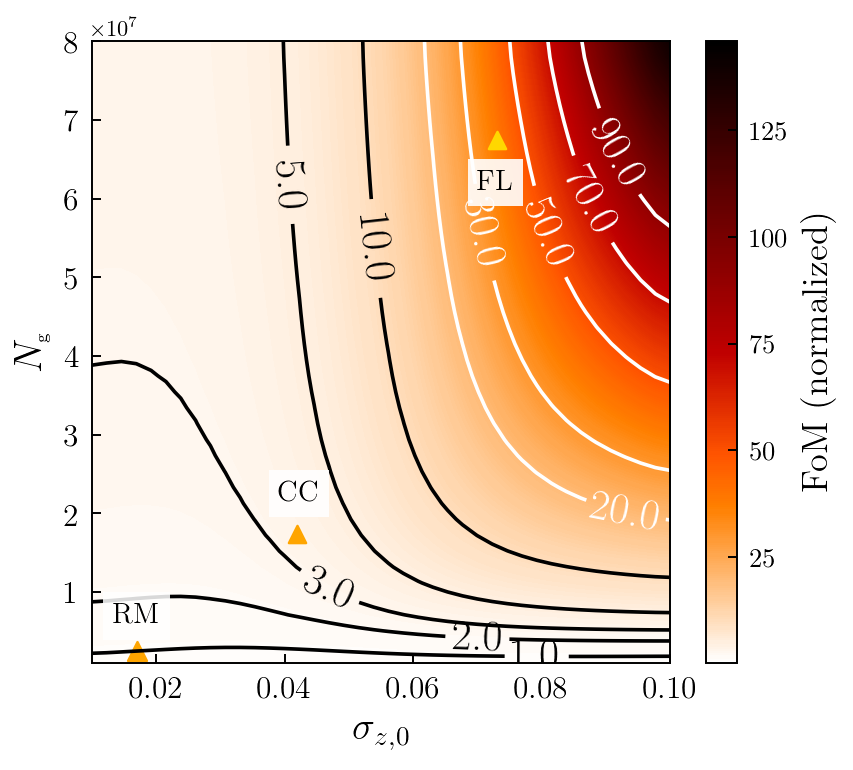

In [71]:
plot_pretty()
import scipy.ndimage
def FoM_free_return(a_1,a_2):
    FoMino = np.copy(FoM_free_norm)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_free = np.copy(FoM_free_return(a_1, a_2))

FoM_free = scipy.ndimage.gaussian_filter(FoM_free, 1)
levels = np.linspace(np.min(FoM_free_norm),np.max(FoM_free_norm),300)
image = plt.contourf(a_1, a_2, FoM_free , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_free, [1.0,2,3,5,10,20,30,50, 70,90] , colors=('k','k', 'k', 'k', 'k','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.3)
plt.clabel(C, inline=1, fontsize=18, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(sig_fl,N_g_fl, color='gold', s=50.0, marker='^')
plt.text(0.070, 6.1e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_CC,N_g_CC, color='orange', s=50.0, marker='^')
plt.text(0.039, 2.15e7,'CC', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_rm,N_g_rm, color='orange', s=60.0, marker='^')
plt.text(0.0133, 5.9e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 8.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[25,50,75,100,125,150])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([25,50,75,100,125,150], fontsize=11)

plt.tight_layout()
plt.savefig('With_cross_free.pdf')
plt.show() 

#### II) Conservative priors, $\alpha = 0.4$

- Old type

In [72]:
# Normalize the matrix
# =================================================
FoM_pr_con_tr1 = np.matrix.transpose(np.copy(FoM_pr_con1))
FoM_pr_con_norm1 = np.copy(FoM_pr_con_tr1)/(FoM_rm_con1)

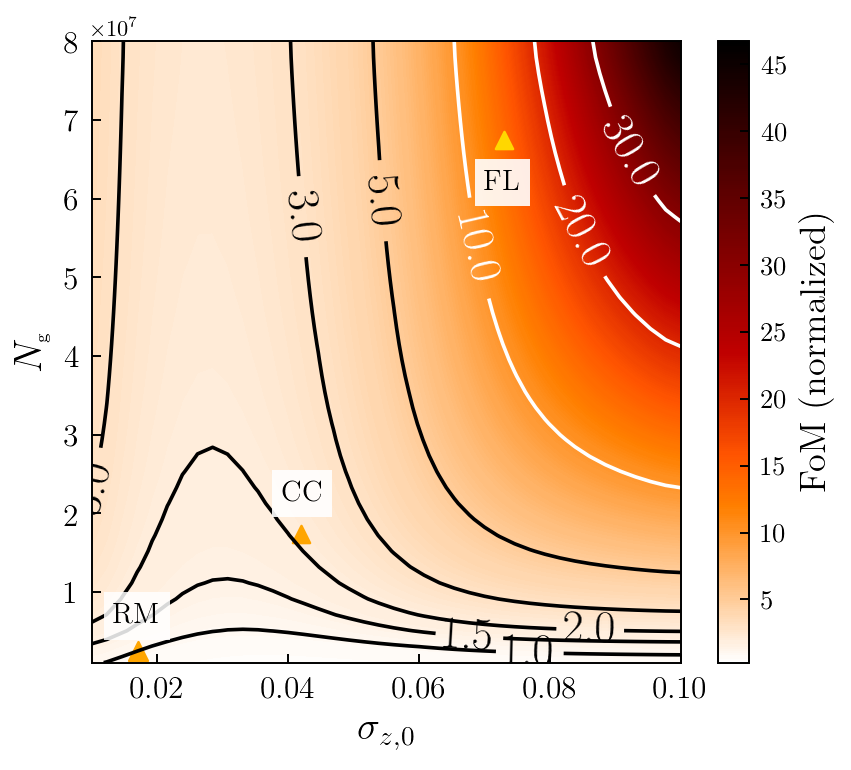

In [73]:
def FoM_pr_con_return1(a_1,a_2):
    FoMino = np.copy(FoM_pr_con_norm1)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr)
FoM_pr_cons1 = np.copy(FoM_pr_con_return1(a_1, a_2))

FoM_pr_cons1 = scipy.ndimage.gaussian_filter(FoM_pr_cons1, 1)
levels = np.linspace(np.min(FoM_pr_con_norm1),np.max(FoM_pr_con_norm1),300)
image = plt.contourf(a_1, a_2, FoM_pr_cons1 , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr_cons1, [1.0,1.5,2.0,3.0,5,10,20,30] , colors=('k','k', 'k', 'k', 'k','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.3)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(sig_fl,N_g_fl, color='gold', s=50.0, marker='^')
plt.text(0.070, 6.10e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_CC,N_g_CC, color='orange', s=50.0, marker='^')
plt.text(0.039, 2.15e7,'CC', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_rm,N_g_rm, color='orange', s=60.0, marker='^')
plt.text(0.0133, 5.9e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 8.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[5,10,15,20,25,30,35,40,45,50])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([5,10,15,20,25,30,35,40,45,50], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_cons_priors1.pdf')
plt.show() 

- New type

In [74]:
# Normalize the matrix
# =================================================
FoM_pr_con_tr2 = np.matrix.transpose(np.copy(FoM_pr_con2))
FoM_pr_con_norm2 = np.copy(FoM_pr_con_tr2)/(FoM_rm_con2)

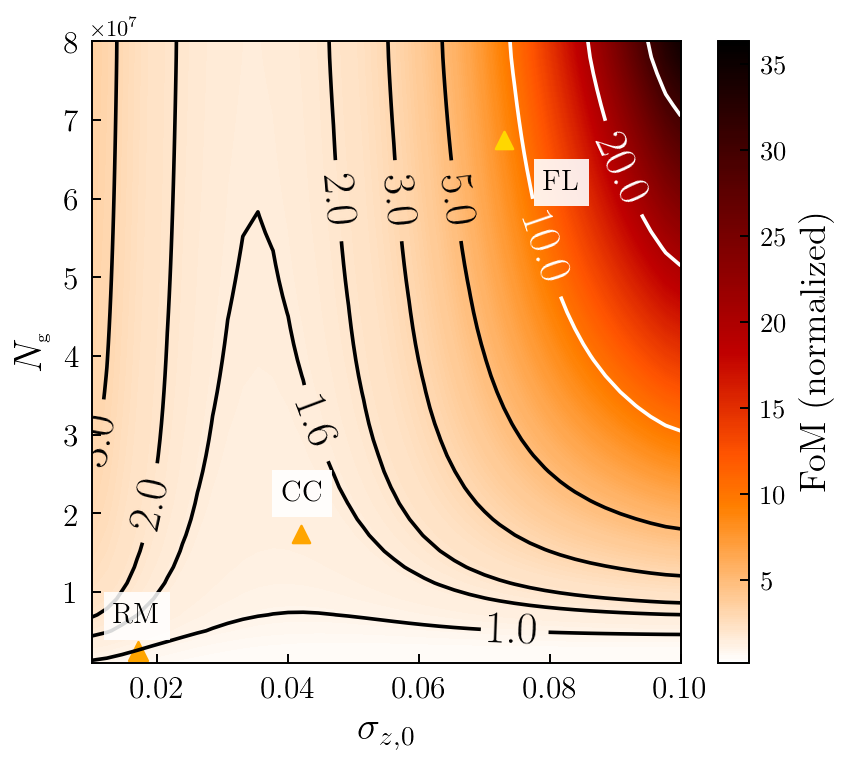

In [75]:
def FoM_pr_con_return2(a_1,a_2):
    FoMino = np.copy(FoM_pr_con_norm2)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr)
FoM_pr_cons2 = np.copy(FoM_pr_con_return2(a_1, a_2))

FoM_pr_cons2 = scipy.ndimage.gaussian_filter(FoM_pr_cons2, 1)
levels = np.linspace(np.min(FoM_pr_con_norm2),np.max(FoM_pr_con_norm2),300)
image = plt.contourf(a_1, a_2, FoM_pr_cons2 , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr_cons2, [1.0,1.6,2.0,3.0,5,10,20,30] , colors=('k','k', 'k', 'k', 'k','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.3)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(sig_fl,N_g_fl, color='gold', s=50.0, marker='^')
plt.text(0.079, 6.10e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_CC,N_g_CC, color='orange', s=50.0, marker='^')
plt.text(0.039, 2.15e7,'CC', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_rm,N_g_rm, color='orange', s=60.0, marker='^')
plt.text(0.0133, 5.9e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 8.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[5,10,15,20,25,30,35,40,45,50])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([5,10,15,20,25,30,35,40,45,50], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_cons_priors2.pdf')
plt.show() 

#### III) Optimistic priors, $\alpha = 0.04$

- Old case

In [76]:
# Normalize the matrix now
# =================================================
FoM_pr_opt_tr1 = np.matrix.transpose(np.copy(FoM_pr_opt1))
FoM_pr_opt_norm1 = np.copy(FoM_pr_opt_tr1)/(FoM_rm_opt1)

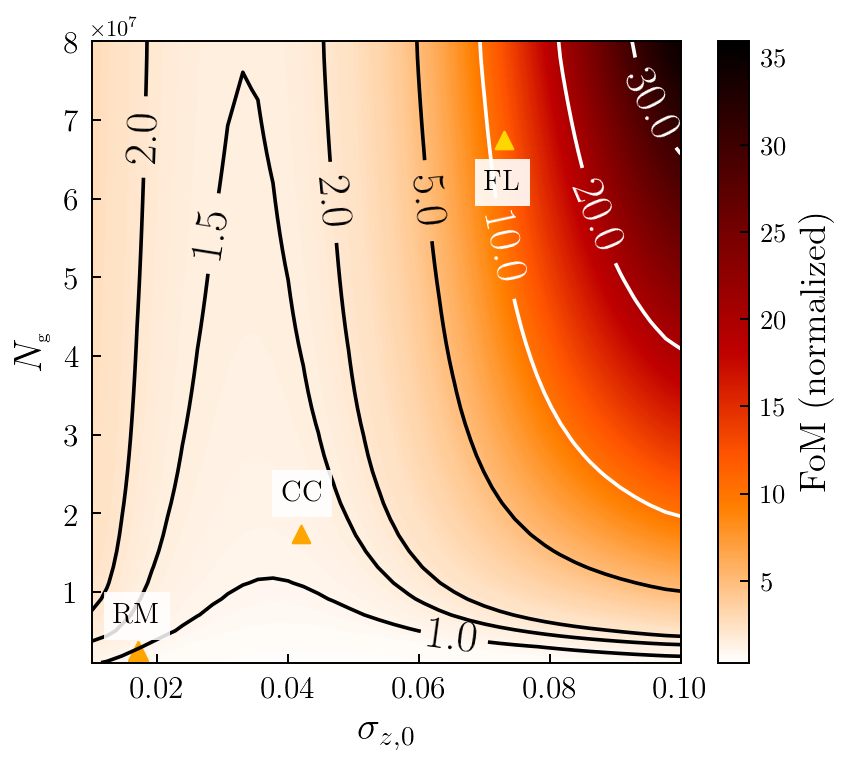

In [77]:
def FoM_pr_opt_return1(a_1,a_2):
    FoMino = np.copy(FoM_pr_opt_norm1)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_pr_opt1 = np.copy(FoM_pr_opt_return1(a_1, a_2))

FoM_pr_opt1 = scipy.ndimage.gaussian_filter(FoM_pr_opt1, 1)
levels = np.linspace(np.min(FoM_pr_opt_norm1),np.max(FoM_pr_opt_norm1),300)
image = plt.contourf(a_1, a_2, FoM_pr_opt1 , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr_opt1, [1.0,1.5,2.0,5.0,10,20,30] , colors=('k','k', 'k', 'k', 'w','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.4)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(sig_fl,N_g_fl, color='gold', s=50.0, marker='^')
plt.text(0.070, 6.1e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_CC,N_g_CC, color='orange', s=50.0, marker='^')
plt.text(0.039, 2.15e7,'CC', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_rm,N_g_rm, color='orange', s=60.0, marker='^')
plt.text(0.0133, 5.9e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 8.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[5,10,15,20,25,30,35])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([5,10,15,20,25,30,35], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_optim_priors1.pdf')
plt.show() 

- New

In [78]:
# Normalize the matrix now
# =================================================
FoM_pr_opt_tr2 = np.matrix.transpose(np.copy(FoM_pr_opt2))
FoM_pr_opt_norm2 = np.copy(FoM_pr_opt_tr2)/(FoM_rm_opt2)

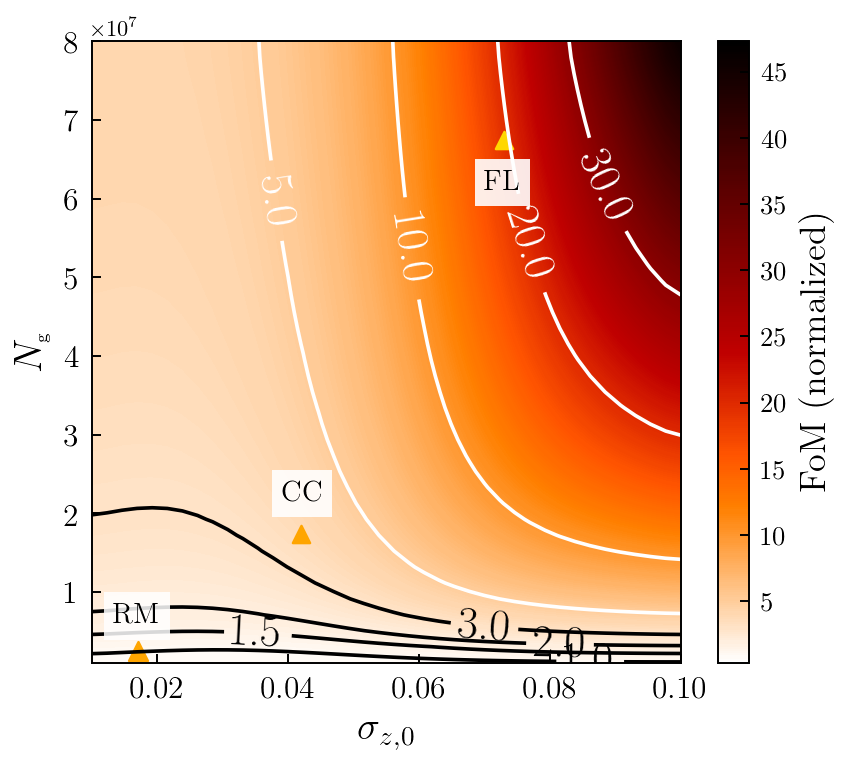

In [79]:
def FoM_pr_opt_return2(a_1,a_2):
    FoMino = np.copy(FoM_pr_opt_norm2)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_pr_opt2 = np.copy(FoM_pr_opt_return2(a_1, a_2))

FoM_pr_opt2 = scipy.ndimage.gaussian_filter(FoM_pr_opt2, 1)
levels = np.linspace(np.min(FoM_pr_opt_norm2),np.max(FoM_pr_opt_norm2),300)
image = plt.contourf(a_1, a_2, FoM_pr_opt2 , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr_opt2, [1.0,1.5,2.0,3.0,5.0,10,20,30] , colors=('k','k', 'k', 'k', 'w','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.4)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(sig_fl,N_g_fl, color='gold', s=50.0, marker='^')
plt.text(0.070, 6.10e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_CC,N_g_CC, color='orange', s=50.0, marker='^')
plt.text(0.039, 2.15e7,'CC', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_rm,N_g_rm, color='orange', s=60.0, marker='^')
plt.text(0.0133, 5.9e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 8.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[5,10,15,20,25,30,35,40,45])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([5,10,15,20,25,30,35,40,45], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_optim_priors2.pdf')
plt.show() 

#### IV) Fixed photo-zs

- Old

In [80]:
# Normalize the matrix
# =================================================
FoM_fixed_tr1 = np.matrix.transpose(np.copy(FoM_fixed1))
FoM_fixed_norm1 = np.copy(FoM_fixed_tr1)/(FoM_rm_fix1)

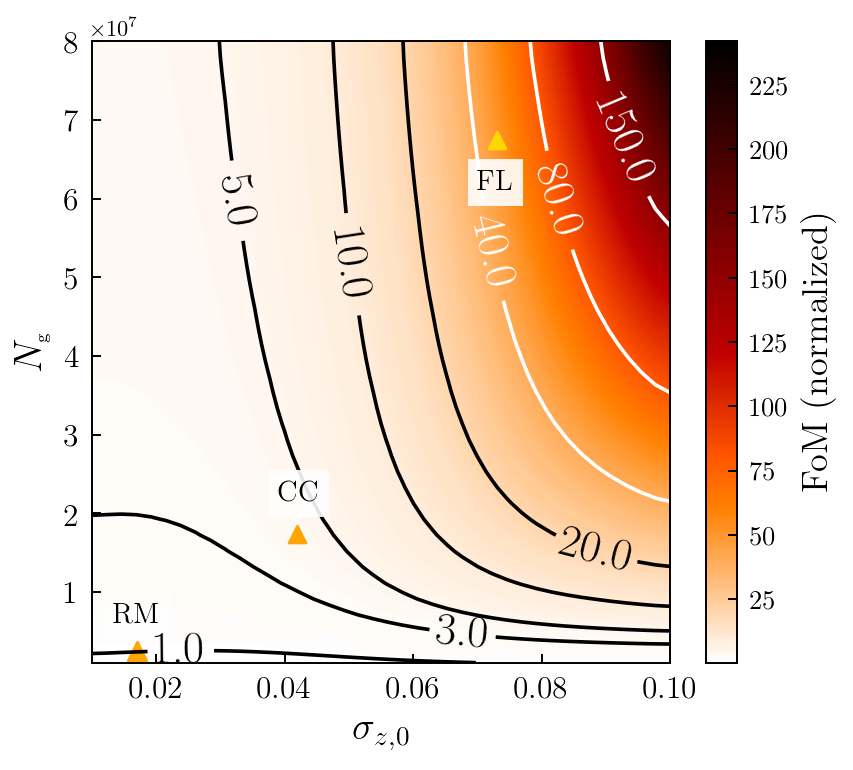

In [81]:
def FoM_fix_return1(a_1,a_2):
    FoMino = np.copy(FoM_fixed_norm1)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_fix_pr1 = np.copy(FoM_fix_return1(a_1, a_2))

FoM_fix_pr1 = scipy.ndimage.gaussian_filter(FoM_fix_pr1, 1)
levels = np.linspace(np.min(FoM_fixed_norm1),np.max(FoM_fixed_norm1),300)
image = plt.contourf(a_1, a_2, FoM_fix_pr1 , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_fix_pr1, [1.0,3,5,10,20,40,80,150] , colors=('k','k', 'k', 'k', 'k','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.4)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(sig_fl,N_g_fl, color='gold', s=50.0, marker='^')
plt.text(0.070, 6.10e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_CC,N_g_CC, color='orange', s=50.0, marker='^')
plt.text(0.039, 2.15e7,'CC', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(sig_rm,N_g_rm, color='orange', s=60.0, marker='^')
plt.text(0.0133, 5.9e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 8.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[25,50,75,100,125,150,175,200,225])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([25,50,75,100,125,150,175,200,225], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_fixed_phot1.pdf')
plt.show() 

In [82]:
print(FoM_rm_free)
print(FoM_rm_con1)
print(FoM_rm_opt1)
print(FoM_rm_fix1)

4301.6521634393075
14062.4747311969
50965.38493857575
88585.73651285711


In [83]:
print(FoM_rm_free)
print(FoM_rm_con2)
print(FoM_rm_opt2)
print(FoM_rm_fix2)

4301.6521634393075
61172.16362484098
87952.1078215027
88585.73651285711


In [84]:
print(FoM_rm_con1/FoM_rm_free)
print(FoM_rm_opt1/FoM_rm_free)
print(FoM_rm_fix1/FoM_rm_free)

3.2690868989168815
11.84786286807237
20.59342158479639
